### White Munia vocalizations
Source:
- https://www.ncbi.nlm.nih.gov/pubmed/24284561
- https://datadryad.org//resource/doi:10.5061/dryad.6pt8g

In [ ]:
/mnt/cube/Datasets/WhiteMunia/readme.txt

In [1]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython
from datetime import datetime

In [2]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [3]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [4]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [5]:
DSLOC = Path('/mnt/cube/Datasets/WhiteMunia')

In [6]:
WAVLIST = list((DSLOC / 'WM').expanduser().glob('*/*.WAV')) + list((DSLOC / 'WM').expanduser().glob('*/*.wav'))
len(WAVLIST), WAVLIST[0]

(179, PosixPath('/mnt/cube/Datasets/WhiteMunia/WM/WM24/7.WAV'))

In [7]:
wav_df = pd.DataFrame(columns=['wavloc', 'indv', 'wav_num', 'vocdata','rate', 'voc_len'])
for wf in WAVLIST:
    indv = wf.parent.stem
    wav_num = wf.stem
    rate, data = load_wav(wf)
    if data is None:
        continue
    wav_df.loc[len(wav_df)] = [wf, indv, wav_num, data, rate, len(data)/rate]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


File format b'\x00\x05\x16\x07'... not understood.
File format b'\x00\x05\x16\x07'... not understood.


In [8]:
print(len(wav_df))
wav_df[:3]

177


,wavloc,indv,wav_num,vocdata,rate,voc_len
0,/mnt/cube/Datasets/WhiteMunia/WM/WM24/7.WAV,WM24,7,"[1200, 1682, 1725, 1529, 1270, 1037, 868, 763,...",48000,18.618250
1,/mnt/cube/Datasets/WhiteMunia/WM/WM24/9.WAV,WM24,9,"[-2600, -2302, -1404, -382, 398, 904, 1196, 12...",48000,7.645313
2,/mnt/cube/Datasets/WhiteMunia/WM/WM24/11.WAV,WM24,11,"[-2054, -2207, -2170, -1905, -1430, -863, -438...",48000,11.470688


### Create spectrograms

In [9]:
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix

In [10]:
win_length_ms = 5
hop_length_ms = 1
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-60,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=64,
    mel_lower_edge_hertz=200,
    mel_upper_edge_hertz=15000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

240.0
48.0


In [11]:
wav_df[:3]

,wavloc,indv,wav_num,vocdata,rate,voc_len
0,/mnt/cube/Datasets/WhiteMunia/WM/WM24/7.WAV,WM24,7,"[1200, 1682, 1725, 1529, 1270, 1037, 868, 763,...",48000,18.618250
1,/mnt/cube/Datasets/WhiteMunia/WM/WM24/9.WAV,WM24,9,"[-2600, -2302, -1404, -382, 398, 904, 1196, 12...",48000,7.645313
2,/mnt/cube/Datasets/WhiteMunia/WM/WM24/11.WAV,WM24,11,"[-2054, -2207, -2170, -1905, -1430, -863, -438...",48000,11.470688


In [12]:
len(wav_df)

177

In [13]:
np.unique(wav_df.indv)

array(['WM01', 'WM02', 'WM03', 'WM04', 'WM05', 'WM06', 'WM07', 'WM08',
       'WM09', 'WM10', 'WM11', 'WM12', 'WM13', 'WM14', 'WM15', 'WM16',
       'WM17', 'WM18', 'WM19', 'WM20', 'WM21', 'WM22', 'WM23', 'WM24',
       'WM25', 'WM26', 'WM27', 'WM28', 'WM29', 'WM30', 'WM31', 'WM32',
       'WM33', 'WM34', 'WM35', 'WM36', 'WM37', 'WM38', 'WM39', 'WM40',
       'WM41', 'WM42', 'WM43', 'WM44'], dtype=object)

In [21]:
len(np.unique(wav_df.indv))

44

In [14]:
"{} minutes of song total".format(round(np.sum(wav_df.voc_len)/60,1))

'291.8 minutes of song total'

In [18]:
audio = int16_to_float32(wav_df.vocdata.values[4])[:rate*10]
spectrogram = sg.spectrogram(audio, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

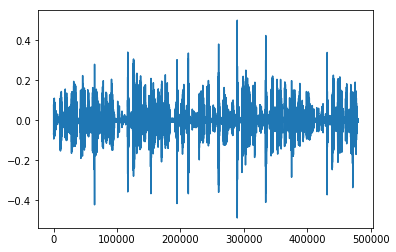

In [19]:
plt.plot(audio)
IPython.display.Audio(data=audio, rate=rate)

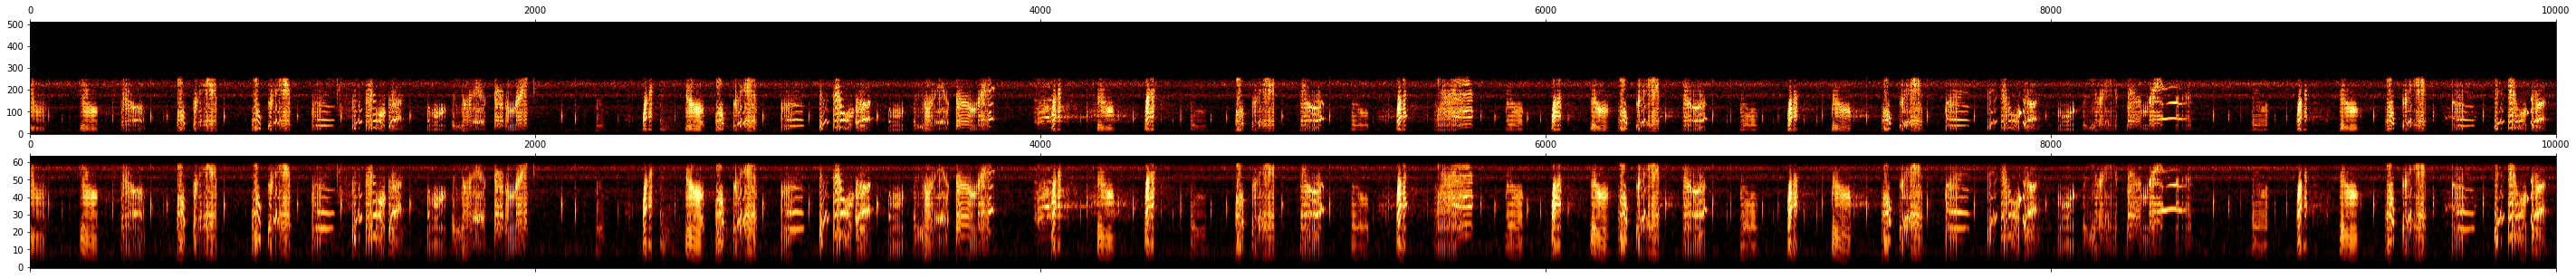

In [20]:
fig, axs = plt.subplots(nrows = 2, figsize=(50,5))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')